In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import numpy as np
from matplotlib.ticker import MultipleLocator
from datetime import datetime
import selenium
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import Select, WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.common.exceptions import NoSuchElementException

In [2]:
#Url de pagina a scrapear
page_url: str = 'https://www.adamchoi.co.uk/teamgoals/detailed'

EXERCISE 1

Obtener los paises, sus ligas y sus temporadas disponbles, almacenar los nombres en un DataFrame y guardar el resultado en un archivo CSV.

In [3]:
def select_to_list(select_tag: webdriver.Chrome) -> list[str]:
    return select_tag.text.split('\n')

browser: webdriver.Chrome = webdriver.Chrome()
browser.get(page_url)

#Buscamos panel de opciones para cambiar pais, liga y temporada
select_panel: webdriver.Chrome = browser.find_element(By.CSS_SELECTOR, 'div.panel > div.panel-body')

#Buscamos tag select en la que estan los paises con data disponible 
countries_select: webdriver.Chrome = select_panel.find_element(By.ID, 'country')
countries: list[str] = select_to_list(countries_select)

#Declaramos matriz en la que almacenaramos cada fila con los datos
data: list[list[str]] = []

for country in countries:
    #Seleccionamos cada pais de la lista
    Select(countries_select).select_by_visible_text(country)
    #En el pais de la iteracion obtenemos sus ligas disponibles
    leagues_select: webdriver.Chrome = select_panel.find_element(By.ID, 'league')
    leagues: list[str] = select_to_list(leagues_select)
    for league in leagues:
        #Seleccionamos cada liga del pais y obtenemos las temporadas disponibles de cada una de ellas
        Select(leagues_select).select_by_visible_text(league)
        seasons: list[str] = select_to_list(select_panel.find_element(By.ID, 'season')) 
        for season in seasons:
            #Agregamos lista con la data
            data.append([country, league, season])
            
browser.quit()

#Creamos dataframe con la info recolectada y sus columnas
df: pd.DataFrame = pd.DataFrame(data, columns=['Country', 'League', 'Season'])
df.to_csv(fr'files\countries_data.csv')
df

,Country,League,Season
0,England,Premier League,2024/2025
1,England,Premier League,23/24
2,England,Premier League,22/23
3,England,Premier League,21/22
4,England,Championship,2024/2025
...,...,...,...
215,USA,US MLS,2023
216,USA,US MLS,2022
217,USA,USL Championship,2024
218,USA,US NWSL,2024


EXERCISE 2

Filtrar las 5 pincipales ligas de europa por la temporada 22-23 y extraer partidos, guardar los datos en un archivo CSV con las columnas: Fecha, Equipo Local, Goles Locales, Equipo Visitante, Goles Visitantes.

In [4]:
europe_main: dict[str] = {
    'England': 'Premier League', 'Spain': 'La Liga',
    'Germany': 'Bundesliga', 'Italy': 'Serie A',
    'France': 'Ligue 1',
}

#Ejecutamos el driver sin interfaz grafica ni carga de imagenes para mejorar velocidad
options: webdriver.ChromeOptions = webdriver.ChromeOptions()
options.add_argument('--headless')
options.add_argument('--blink-settings=imagesEnabled=false')
browser: webdriver.Chrome = webdriver.Chrome(options=options)

browser.get(page_url)

main_data: list[str] = [] 

for country, league in europe_main.items():
    try:
        """Para cada select del panel buscamos el elemento, esperamos hasta que sea clickeable y seleccionamos
        el correspondiente valor de la iteracion"""
        print(f"Scrapping {league}...", end=' ')
        #Iniciamos contador de tiempo para hallar cuanto tarda en scrapear cada liga
        start: datetime = datetime.now()
        
        country_panel: webdriver.Chrome = browser.find_element(By.ID, 'country') 
        WebDriverWait(browser, 10).until(EC.element_to_be_clickable(country_panel))
        Select(country_panel).select_by_visible_text(country)

        league_panel: webdriver.Chrome = browser.find_element(By.ID, 'league') 
        WebDriverWait(browser, 10).until(EC.text_to_be_present_in_element((By.ID, 'league'), league))
        Select(league_panel).select_by_visible_text(league)
    
        season_panel: webdriver.Chrome = browser.find_element(By.ID, 'season') 
        WebDriverWait(browser, 10).until(EC.element_to_be_clickable(season_panel))
        #Para todos seleccionamos la temporada 2022-2023
        Select(season_panel).select_by_visible_text('22/23')
        
        #Agregamos wait para esperar que las filas de las tablas se carguen correctamente
        WebDriverWait(browser, 10).until(EC.visibility_of_element_located((By.TAG_NAME, 'tr')))
        tables_rows: list = browser.find_elements(By.TAG_NAME, 'tr')
        
        for row in tables_rows:
            #Localizamos cada dato de la fila para capturarlo y almacenarlo en la variable correspondiente  
            data: list = row.find_elements(By.TAG_NAME, 'td')
            for i, datum in enumerate(data):
                if i == 0:
                    date = datum.text
                elif i == 1:
                    local_team = datum.text
                elif i == 2:
                    result = datum.text
                    local_goals = result.split(' - ')[0]
                    away_goals = result.split(' - ')[1]
                elif i == 3:
                    away_team = datum.text
            
            main_data.append([country, league, date, local_team, local_goals, away_goals, away_team])
        
        #Restamos el inicio y final del tiempo para obtener el tiempo que tardo en la iteracion
        end: datetime = datetime.now()
        print(f"scrapped in {end-start}")
        
    except NoSuchElementException:
        print('Element not found')
        continue        

browser.quit()

main_leagues_df: pd.DataFrame = pd.DataFrame(main_data, columns=['Country', 'League', 'Date', 'Local', 'Local Goals', 'Away Goals', 'Away']).drop_duplicates().reset_index(drop=True)
main_leagues_df.to_csv(fr'files\main_leagues.csv')
main_leagues_df

Scrapping Premier League... scrapped in 0:00:53.996619
Scrapping La Liga... scrapped in 0:00:54.046380
Scrapping Bundesliga... scrapped in 0:00:42.443396
Scrapping Serie A... scrapped in 0:00:54.851099
Scrapping Ligue 1... scrapped in 0:00:50.979499


,Country,League,Date,Local,Local Goals,Away Goals,Away
0,England,Premier League,12-08-2022,Arsenal,4,2,Leicester
1,England,Premier League,26-08-2022,Arsenal,2,1,Fulham
2,England,Premier League,30-08-2022,Arsenal,2,1,Aston Villa
3,England,Premier League,30-09-2022,Arsenal,3,1,Tottenham
4,England,Premier League,08-10-2022,Arsenal,3,2,Liverpool
...,...,...,...,...,...,...,...
1824,France,Ligue 1,28-01-2023,Strasbourg,1,2,Toulouse
1825,France,Ligue 1,22-10-2022,Toulouse,2,2,Strasbourg
1826,France,Ligue 1,20-05-2023,Troyes,1,1,Strasbourg
1827,France,Ligue 1,31-01-2023,Toulouse,4,1,Troyes


EXERCISE 3

A partir del df anterior:

    3.1 Identificar los 10 equipos con más goles en casa
    3.2 Equipo con mayor promedio de goles en casa y visualiza los resultados en una gráfica de barras.
    3.3 Para cada equipo, calcula el total de goles marcados como local y visitante y genera un gráfico de barras comparativo.

C:\Users\juans\AppData\Local\Temp\ipykernel_13552\2022207329.py:45: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig1.show()
C:\Users\juans\AppData\Local\Temp\ipykernel_13552\2022207329.py:69: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig2.show()


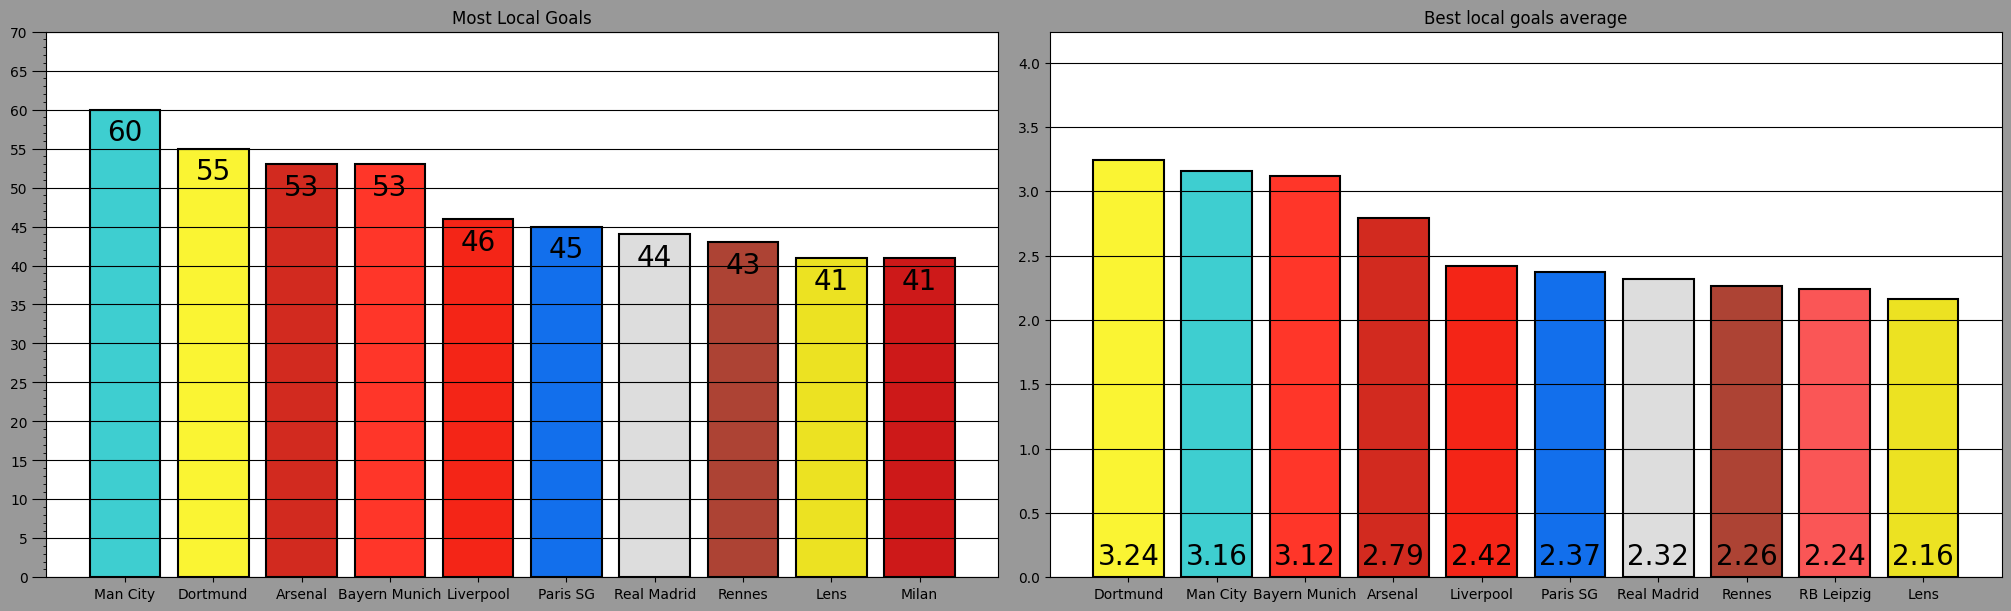

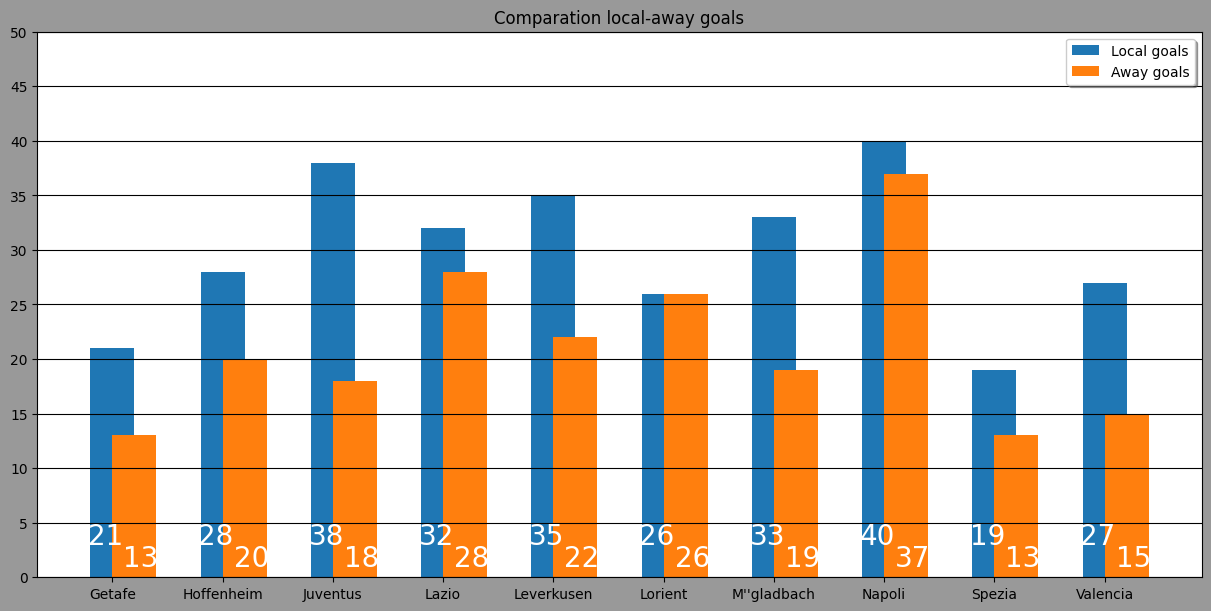

In [5]:
#Configurando tipos de datos de las filas
main_leagues_df['Date'] = pd.to_datetime(main_leagues_df['Date'], format="%d-%m-%Y")
main_leagues_df[['Local Goals', 'Away Goals']] = main_leagues_df[['Local Goals', 'Away Goals']].astype({'Local Goals':'Int64', 'Away Goals':'Int64'})

#3.1 Agrupamos por nombre de equipo local y sumamos los goles de la columna local goals
most_local_goals: pd.DataFrame = main_leagues_df.groupby('Local')['Local Goals'].sum().sort_values(ascending=False).head(10).reset_index()

colors = ['#3eced0', '#faf433', '#d22a1f', '#ff3629',  '#f42517', '#126fec', '#dddddd', '#ad4334', '#ece222', '#cd1919']
fig1, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 6), facecolor='#999999', layout='constrained')
axes[0].bar(most_local_goals['Local'], most_local_goals['Local Goals'], color=colors, linewidth=1.5, edgecolor='000000')
axes[0].set(title='Most Local Goals', ylim=(0, most_local_goals['Local Goals'].max()+10))
axes[0].yaxis.set_major_locator(MultipleLocator(5))
axes[0].set_yticks([i for i in range(0, 71)], minor=True)
axes[0].tick_params(axis='y', which='major', size=10)
axes[0].grid(axis='y', color='#000000')

for i, goals in enumerate(most_local_goals['Local Goals']):
    axes[0].text(i, goals-4, s=str(goals), zorder=10, ha='center', fontsize=20)

#3.2 Agrupamos por nombre de equipo local para obtener los goles de local de cada equipo y lo mismo para visitante
local_goals_by_team: pd.DataFrame = main_leagues_df.groupby('Local')['Local Goals'].agg(['sum', 'count'])
local_goals_by_team = local_goals_by_team.reset_index().rename(columns={'sum': 'Local Goals', 'count': 'Local Matches'})
away_goals_by_team: pd.DataFrame = main_leagues_df.groupby('Away')['Away Goals'].agg(['sum', 'count'])
away_goals_by_team = away_goals_by_team.reset_index().rename(columns={'sum': 'Away Goals', 'count': 'Away Matches'})
#Unimos los dataframes y borramos columna innecesaria
total_goals: pd.DataFrame = local_goals_by_team.merge(away_goals_by_team, how='inner', left_on='Local', right_on='Away').drop(columns='Away')
#Creamos nuevas columnas a partir de ciertas operaciones
total_goals['Total Goals'] = total_goals['Local Goals'] + total_goals['Away Goals'] 
total_goals['Total Matches'] = total_goals['Local Matches'] + total_goals['Away Matches'] 
total_goals.rename(columns={'Local': 'Team'}, inplace=True)
total_goals = total_goals[['Team', 'Local Goals', 'Away Goals', 'Total Goals', 'Local Matches', 'Away Matches', 'Total Matches']]
#Calculamos los equipos con mejor promedio de goles en casa
best_avg_goals: pd.DataFrame = total_goals.drop(columns=[col for col in total_goals.columns if col != 'Team' and not re.match(r'^Local', col)])
best_avg_goals['Average Goals'] = round(best_avg_goals['Local Goals'] / best_avg_goals['Local Matches'], 2)
best_avg_goals = best_avg_goals.sort_values('Average Goals', ascending=False).head(10).reset_index(drop=True)

colors = ['#faf433', '#3eced0', '#ff3629', '#d22a1f',  '#f42517', '#126fec', '#dddddd', '#ad4334', '#fa5656', '#ece222']
axes[1].bar(best_avg_goals['Team'], best_avg_goals['Average Goals'], linewidth=1.5, edgecolor='000000', color=colors)
axes[1].set(title='Best local goals average', ylim=(0, best_avg_goals['Average Goals'].max()+1.0))
axes[1].grid(axis='y', color='#000000')

for i, avg in enumerate(best_avg_goals['Average Goals']):
    axes[1].text(i, 0.1, s=str(avg), zorder=10, ha='center', fontsize=20)

fig1.show()

#3.3 Del df del punto anterior tomamos los goles de local y visita 
local_away_goals: pd.DataFrame = total_goals.drop(columns=[col for col in total_goals.columns if col != 'Team' and not re.search(r'Goals$', col)])

#Tomamos 10 equipos aleatorios 
random_teams = np.random.choice(local_away_goals['Team'], 10)
local_away_goals = local_away_goals[local_away_goals['Team'].isin(random_teams)].reset_index(drop=True)

fig2, ax = plt.subplots(figsize=(12, 6), facecolor='#999999', layout='constrained')

ax.bar(local_away_goals['Team'], local_away_goals['Local Goals'], label='Local goals', width=.4)
ax.bar(local_away_goals['Team'], local_away_goals['Away Goals'], label='Away goals', width=.4, align='edge')    
ax.set(title='Comparation local-away goals', ylim=(0, local_away_goals['Local Goals'].max()+10))
ax.yaxis.set_major_locator(MultipleLocator(5))
ax.legend(shadow=True)
ax.grid(axis='y', color='#000000')

i: int = 0 
for local, away in zip(local_away_goals['Local Goals'], local_away_goals['Away Goals']):
    ax.text(i+.1, 3, s=str(local), zorder=10, ha='right', va='baseline', fontsize=20, color='#ffffff')
    ax.text(i+.1, 3, s=str(away), zorder=10, ha='left', va='top', fontsize=20, color='#ffffff')
    i += 1

fig2.show()

EXERCISE 4

A partir del df anterior:

    4.1 Calcular el promedio de goles por partido en cada liga y crear un gráfico de barras horizontales ordenado por promedio de goles.
    4.2 Usa numpy y pandas para calcular la correlación entre goles locales y visitantes. 
    4.3 Identificar partidos que están fuera del promedio en términos de goles (usando desviación estándar), crear tabla con estos partidos y destaca los valores extremos en una gráfica.

-0.08370253670881854 The correlation is negative, which means that while one variable increases, the other decreases. 
    However, this value is very close to 0, so the relationship is very weak
    Country          League        Date           Local  Local Goals  \
0   England  Premier League  26-08-2022       Liverpool            9   
1   England  Premier League  04-11-2022           Leeds            4   
2   England  Premier League  02-09-2022       Brentford            5   
3   England  Premier League  03-09-2022        Brighton            5   
4   England  Premier League  28-04-2023  Crystal Palace            4   
..      ...             ...         ...             ...          ...   
74   France         Ligue 1  28-12-2022       Marseille            6   
75   France         Ligue 1  01-04-2023          Monaco            4   
76   France         Ligue 1  12-08-2022        Paris SG            5   
77   France         Ligue 1  10-01-2023            Nice            6   
78   France 

C:\Users\juans\AppData\Local\Temp\ipykernel_13552\3135921886.py:35: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


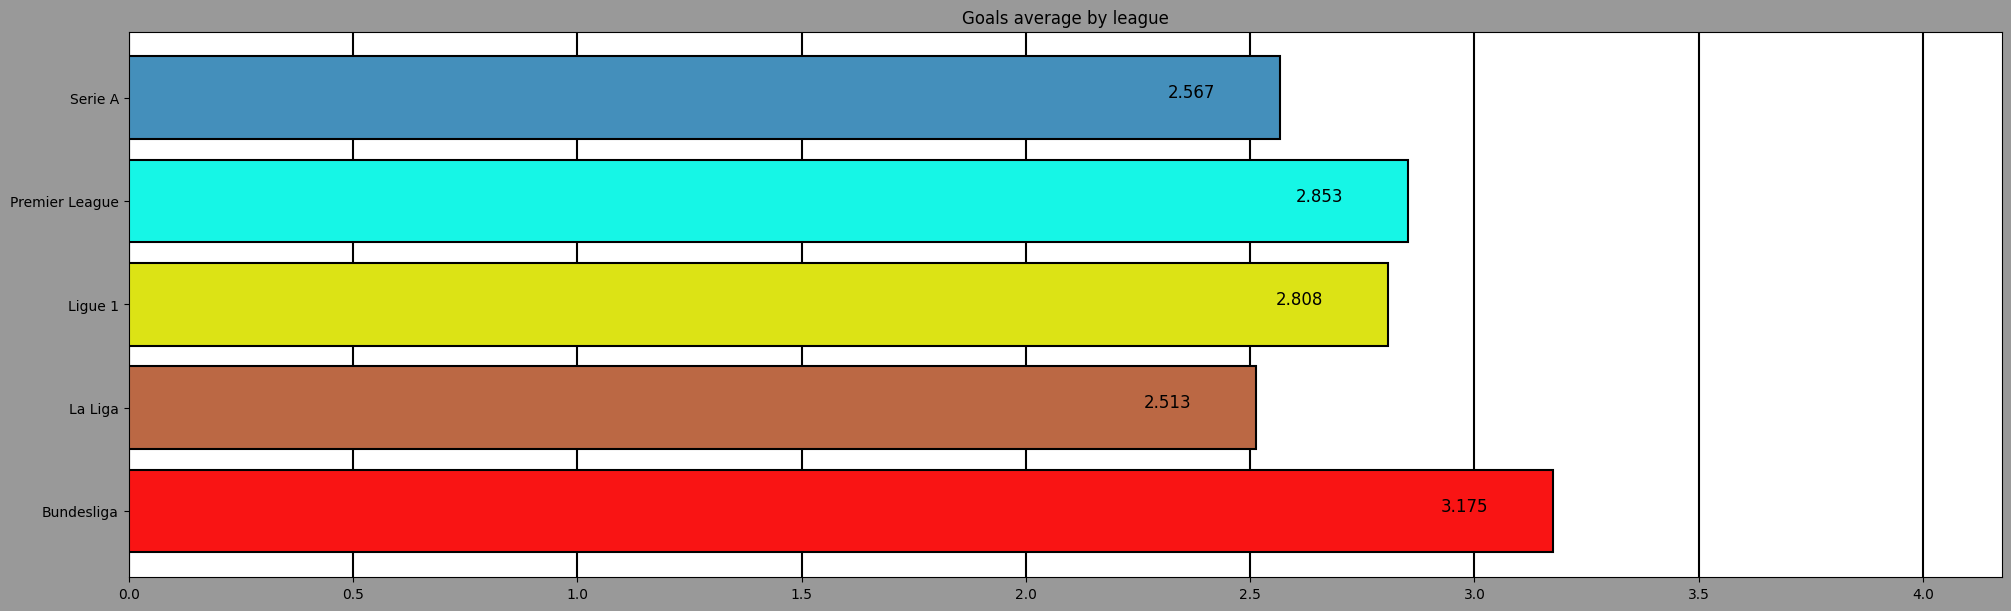

In [6]:
main_leagues_df: pd.DataFrame = pd.read_csv(fr'files\main_leagues.csv').drop(columns=['Unnamed: 0'])

#4.1
main_leagues_df['Matchday Goals'] = main_leagues_df['Local Goals'] + main_leagues_df['Away Goals']
goals_avg: pd.DataFrame = main_leagues_df.groupby('League')['Matchday Goals'].mean().reset_index().rename(columns={'Matchday Goals': 'AVG Goals'})

colors: list[str] = ['#f91414', '#bb6844', '#dce315', '#16f6e6', '#448fbb']
fig, ax = plt.subplots(figsize=(20, 6), facecolor='#999999', layout='constrained')
ax.barh(goals_avg['League'], goals_avg['AVG Goals'], color=colors, zorder=10, linewidth=1.5, edgecolor='#000000')
ax.set(title='Goals average by league', xlim=(0, goals_avg['AVG Goals'].max() + 1.0))
ax.grid(axis='x',linewidth=1.5, color='#000000')

for i, avg in enumerate(goals_avg['AVG Goals']):
    ax.text(avg-.25, i, s=round(avg, 3), fontsize=12, zorder=20)

#4.2
#Usamos numpy para hallar la correlacion y accedemos a la posicion donde se encuentra el resultado
correlate: np.float64 = np.corrcoef(main_leagues_df['Local Goals'], main_leagues_df['Away Goals'])[0, 1]
print(f"""{correlate} The correlation is negative, which means that while one variable increases, the other decreases. 
    However, this value is very close to 0, so the relationship is very weak""")

#4.3
#Agrupamos por liga y hallamos la desviacion estandar de cada una
std_by_league: pd.DataFrame = main_leagues_df.groupby('League')['Matchday Goals'].std(ddof=0).reset_index()
#Unimos con df que contiene el promedio de goles por liga
std_avg_by_league: pd.DataFrame = goals_avg.merge(std_by_league, on='League').rename(columns={'Matchday Goals': 'STD'})
for league, average, std in zip(std_avg_by_league['League'], std_avg_by_league['AVG Goals'], std_avg_by_league['STD']):
    #Filtramos df por liga de iteracion para aplicarle formula para saber si el resultado puede ser atipico 
    filter = main_leagues_df['League'] == league
    main_leagues_df.loc[filter, 'Unusual'] = abs(main_leagues_df['Matchday Goals'] - average) > 2 * std

unusual_matches: pd.DataFrame = main_leagues_df[main_leagues_df['Unusual'] == True].reset_index(drop=True).drop(columns=['Unusual'])
print(unusual_matches)

fig.show()

EXERCISE 5

Crea un histograma con matplotlib para visualizar la distribución de goles marcados por equipo en una temporada.

SCRAPPING DATA

In [7]:
#Data con la temporada a scrappear
country: str = 'Spain'
league: str = 'La Liga'
season: str = '23/24'

#Creamos driver de google sin ejecutar interfa grafica
options: webdriver.ChromeOptions = webdriver.ChromeOptions()
options.add_argument('--headless')
browser: webdriver.Chrome = webdriver.Chrome(options=options)
browser.get(page_url)

#Buscamos el boton para desplegar todos los partidos
browser.find_element(By.XPATH, "//label[@analytics-event='All matches']").click()

country_panel: webdriver.Chrome = browser.find_element(By.ID, 'country')
WebDriverWait(browser, 10).until(EC.text_to_be_present_in_element((By.ID, 'country'), country))
Select(country_panel).select_by_visible_text(country)

league_panel: webdriver.Chrome = browser.find_element(By.ID, 'league')
WebDriverWait(browser, 10).until(EC.text_to_be_present_in_element((By.ID, 'league'), league))
Select(league_panel).select_by_visible_text(league)

season_panel: webdriver.Chrome = browser.find_element(By.ID, 'season')
WebDriverWait(browser, 10).until(EC.text_to_be_present_in_element((By.ID, 'season'), season))
Select(season_panel).select_by_visible_text(season)

#Esperamos que todas las filas con la data esten cargadas
WebDriverWait(browser, 10).until(EC.visibility_of_element_located((By.TAG_NAME, 'tr')))
rows: list = browser.find_elements(By.TAG_NAME, 'tr')

data_league: list[list[str]] = []
for row in rows:
    data = row.find_elements(By.TAG_NAME, 'td')
    for i, datum in enumerate(data):
        if i == 0:
            date: str = datum.text
        elif i == 1:
            local: str = datum.text
        elif i == 2:
            result: list = datum.text.split(' - ')
            local_goals: str = result[0]
            away_goals: str = result[1]
        elif i == 3:
            away: str = datum.text
    
    data_league.append([date, local, local_goals, away_goals, away])

browser.quit()

df_league: pd.DataFrame = pd.DataFrame(data_league, columns=['Date', 'Local', 'Local Goals', 'Away Goals', 'Away']).drop_duplicates().reset_index(drop=True)
df_league.to_json(fr'files\data_league.json', orient='columns')

VISUALIZATION

C:\Users\juans\AppData\Local\Temp\ipykernel_13552\1038564719.py:13: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


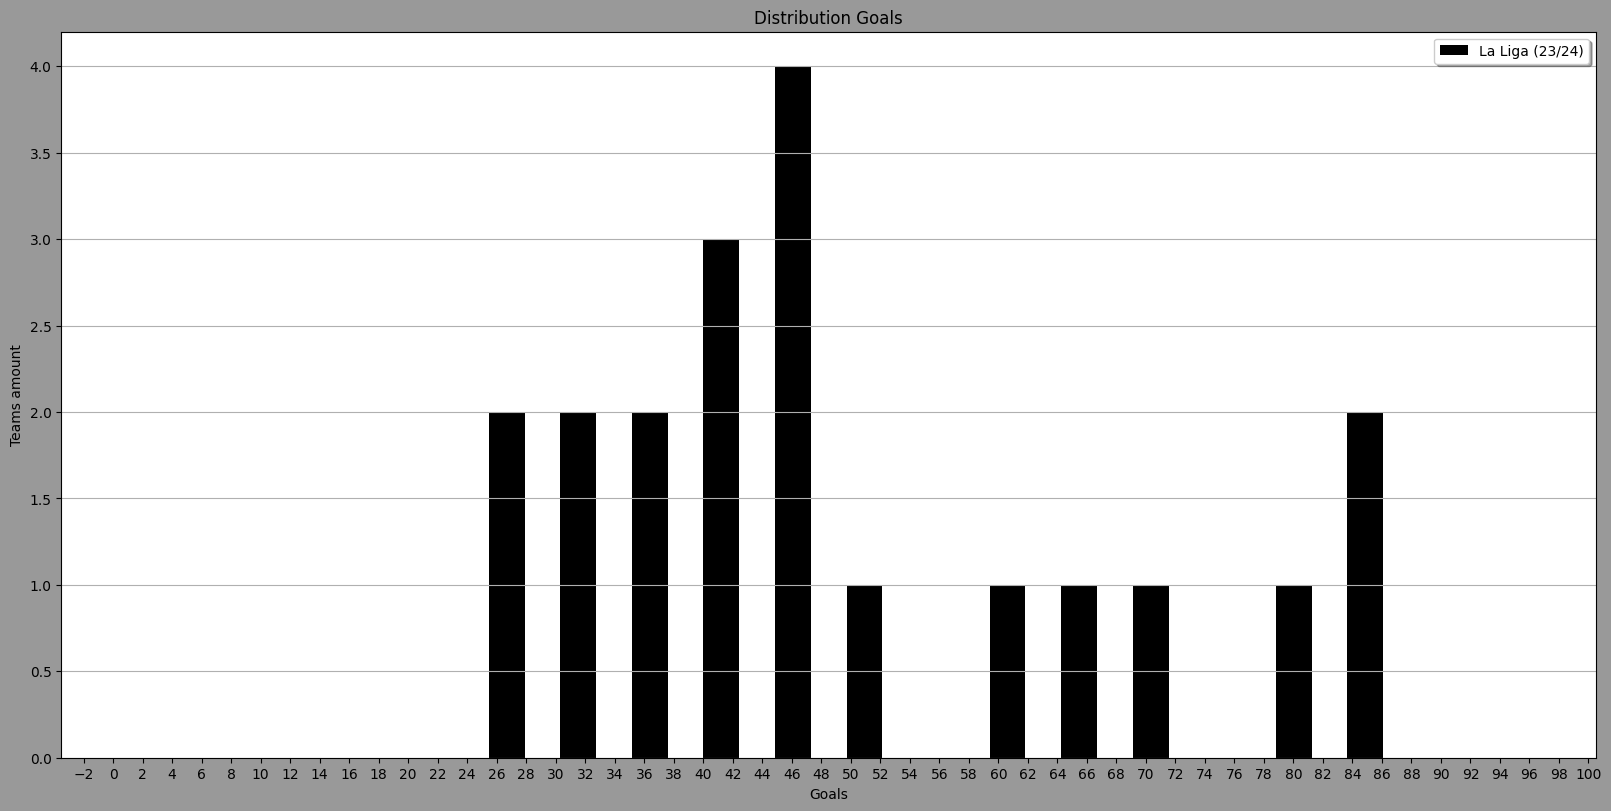

In [10]:
df: pd.DataFrame = pd.read_json(fr'files\data_league.json', convert_dates=['Date'])
goals_by_team: pd.DataFrame = df.groupby('Local')['Local Goals'].sum() + df.groupby('Away')['Away Goals'].sum() 
goals_by_team = goals_by_team.reset_index()
goals_by_team.columns = 'Team', 'Goals'

fig, ax = plt.subplots(figsize=(16, 8), layout='constrained', facecolor='#999999')
ax.hist(goals_by_team['Goals'], bins=20, range=(0, goals_by_team['Goals'].max()+10), rwidth=.5, label=f'{league} ({season})', color='#000000')
ax.set(title='Distribution Goals', xlabel='Goals', ylabel='Teams amount')
ax.legend(shadow=True)
ax.grid(axis='y')
ax.xaxis.set_major_locator(MultipleLocator(2))

fig.show()